## Notebook 01 — Positions Generation (Synthetic Lending Book)

This notebook constructs a reproducible synthetic position book for a
single-collateral lending market (ETH collateral, USD-denominated debt).

Because full borrower-level position data for major lending protocols is
not always available in a clean, public dataset, I generate a synthetic
cross-section of positions using calibrated distributional assumptions
that mimic realistic on-chain behavior (position size is heavy-tailed,
and borrowers cluster around a target LTV band).

The workflow consists of:

	1.	Generating a synthetic population of lending positions (collateral amount, debt amount, target LTV) with a fixed random seed for reproducibility
	2.	Computing initial collateral value from collateral amount and the initial spot price
	3.	Visualizing key distributions (log10 collateral value, target LTV) to validate realism (right-tail “whales”, plausible risk-taking)
	4.	Computing initial Health Factor (HF) under a chosen liquidation threshold (LT) as a baseline risk snapshot
	5.	Reporting the initial liquidatable rate (share of positions with HF < 1) and plotting the HF distribution with the liquidation boundary

The resulting synthetic position book serves as the foundational input
for all subsequent liquidation, bad debt, oracle lag, and policy sweep
stress tests in this project.

In [ ]:
#1. Clone repo + imports
!rm -rf b1-defi-risk
!git clone https://github.com/lydialydia-lydia/b1-defi-risk.git
%cd b1-defi-risk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sim_data import generate_synthetic_positions
from src.risk_metrics import compute_health_factor

Cloning into 'b1-defi-risk'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 25 (delta 6), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 16.00 KiB | 5.33 MiB/s, done.
Resolving deltas: 100% (6/6), done.
/content/b1-defi-risk


In [ ]:
#2. Generate positions (reproducible)
# Reproducibility
SEED = 42

# Generate synthetic positions
positions = generate_synthetic_positions(
    n_positions=10_000,
    collateral_price_init=2_500.0,
    ltv_center=0.62,
    ltv_spread=0.08,
    collateral_logn_mu=0.0,
    collateral_logn_sigma=1.0,
    seed=SEED
)

print("Generated positions:", positions.shape)
positions.head()

Generated positions: (10000, 8)


,position_id,collateral_asset,debt_asset,collateral_amount,debt_amount,collateral_price_init,collateral_value_init,target_ltv
0,1,ETH,USD,1.356241,2149.988760,2500.0,3390.603102,0.634102
1,2,ETH,USD,0.353460,611.424356,2500.0,883.650749,0.691930
2,3,ETH,USD,2.117955,2659.190187,2500.0,5294.888534,0.502218
3,4,ETH,USD,2.561427,3824.058498,2500.0,6403.568725,0.597176
4,5,ETH,USD,0.142127,243.865636,2500.0,355.317168,0.686332


In [ ]:
#3. Basic checks
# Basic sanity checks
print("Columns:", list(positions.columns))
print("Missing values:\n", positions.isna().sum())

# Check totals
print("Total debt:", positions["debt_amount"].sum())
print("Total collateral value:", positions["collateral_value_init"].sum())

Columns: ['position_id', 'collateral_asset', 'debt_asset', 'collateral_amount', 'debt_amount', 'collateral_price_init', 'collateral_value_init', 'target_ltv']
Missing values:
 position_id              0
collateral_asset         0
debt_asset               0
collateral_amount        0
debt_amount              0
collateral_price_init    0
collateral_value_init    0
target_ltv               0
dtype: int64
Total debt: 25542712.62433892
Total collateral value: 41107725.198622584


In [ ]:
from pathlib import Path

FIG_DIR = Path("figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Saving figures to:", FIG_DIR.resolve())

Saving figures to: /content/b1-defi-risk/figures


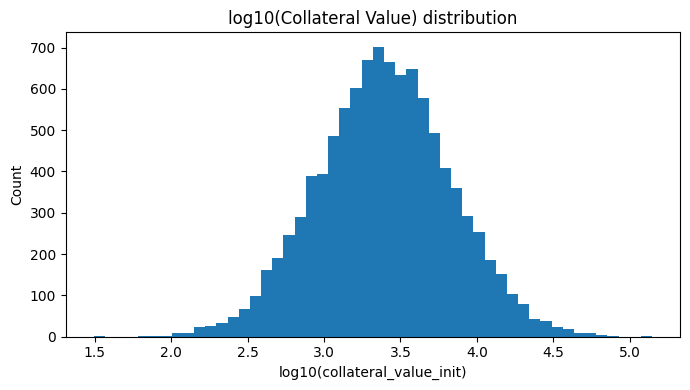

Saved: figures/01_log10_collateral_value_dist.png


<Figure size 640x480 with 0 Axes>

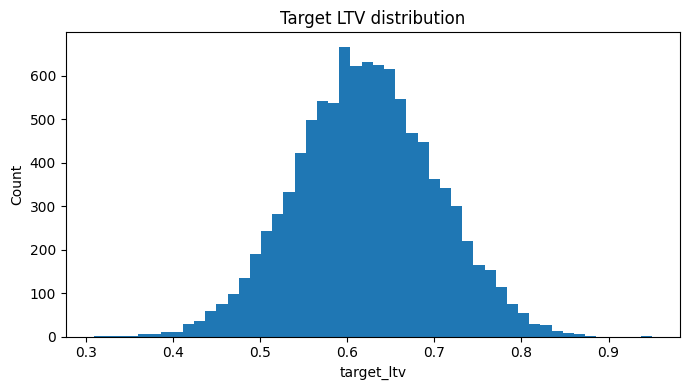

Saved: figures/01_target_ltv_dist.png


<Figure size 640x480 with 0 Axes>

In [ ]:
#4. Plot distributions: log10 collateral value, target LTV
# log10(Collateral Value) distribution
plt.figure(figsize=(7, 4))
plt.hist(np.log10(positions["collateral_value_init"]), bins=50)
plt.title("log10(Collateral Value) distribution")
plt.xlabel("log10(collateral_value_init)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Save
out_path = FIG_DIR / "01_log10_collateral_value_dist.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

# Target LTV distribution
plt.figure(figsize=(7, 4))
plt.hist(positions["target_ltv"], bins=50)
plt.title("Target LTV distribution")
plt.xlabel("target_ltv")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#Save
out_path = FIG_DIR / "01_target_ltv_dist.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

In [ ]:
#5. Initial HF + initial liquidatable rate
# Protocol parameter: liquidation threshold (LT)
LIQUIDATION_THRESHOLD = 0.80

price_init = float(positions["collateral_price_init"].iloc[0])

# Compute initial HF
hf_init = compute_health_factor(
    collateral_amount=positions["collateral_amount"],
    debt_amount=positions["debt_amount"],
    price=price_init,
    liquidation_threshold=LIQUIDATION_THRESHOLD
)

# Attach HF to the position book for downstream notebooks
positions["health_factor_init"] = hf_init
# A position is liquidatable if HF < 1
positions["is_liquidatable_init"] = positions["health_factor_init"] < 1.0

print(positions["health_factor_init"].describe())
init_liq_rate = positions["is_liquidatable_init"].mean()
print(f"Initial liquidatable rate: {init_liq_rate:.4%}")

count    10000.000000
mean         1.309498
std          0.178128
min          0.842105
25%          1.184077
50%          1.288811
75%          1.410961
max          2.589201
Name: health_factor_init, dtype: float64
Initial liquidatable rate: 1.2300%


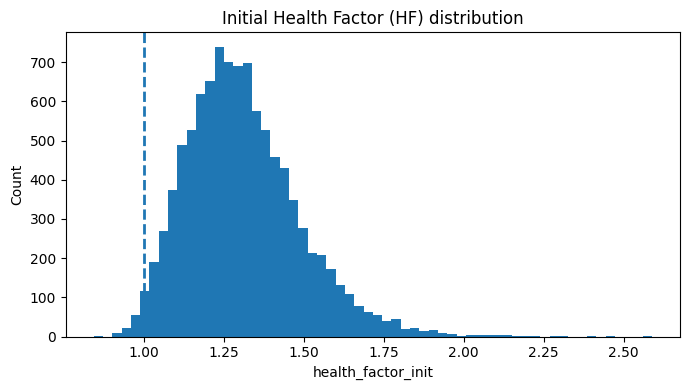

Saved: figures/01_initial_hf_dist.png


In [ ]:
#6. Plot HF distribution
plt.figure(figsize=(7, 4))
plt.hist(positions["health_factor_init"], bins=60)
plt.axvline(1.0, linestyle="--", linewidth=2)  # liquidation boundary

plt.title("Initial Health Factor (HF) distribution")
plt.xlabel("health_factor_init")
plt.ylabel("Count")
plt.tight_layout()


# Save
out_path = FIG_DIR / "01_initial_hf_dist.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", out_path)